In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from ultralytics import YOLO
import cv2
import plotly.graph_objects as go
from fuzzywuzzy import process



c:\Users\marou\miniconda3\envs\wikipedia\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [11]:
import time

In [2]:
from paddleocr import PaddleOCR
ocr= PaddleOCR(lang='en',show_log=False,show_warning=False,use_gpu=True)

In [3]:
model = YOLO("./runs/detect/train16/weights/best.pt")

In [7]:
results = model("C:\\Users\\marou\\Pictures\\Screenshots\\wikisc.png")


image 1/1 C:\Users\marou\Pictures\Screenshots\wikisc.png: 320x640 1 button, 77 links, 3 labels, 13 texts, 12 images, 307.6ms
Speed: 3.0ms preprocess, 307.6ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


In [8]:
img_path="C:\\Users\\marou\\Pictures\\Screenshots\\wikisc.png"

In [9]:
names=model.names
names

{0: 'button',
 1: 'heading',
 2: 'link',
 3: 'label',
 4: 'text',
 5: 'image',
 6: 'iframe'}

In [12]:
def infer(image_path):
    start_time=time.time()
    image = cv2.imread(image_path)
    color = (0, 255, 0)  # Green
    thickness = 2

    results = model.predict(source=image, save=False)
    for elt in results:
        boxes = elt.boxes
        objects = [{} for _ in range(len(boxes))]
        for i, c in enumerate(boxes.cls):
            objects[i]["class"] = names[int(c)]

        box = elt.boxes.xyxy
        boxes_np = box.cpu().numpy()

        for i, row in enumerate(boxes_np):
            x1, y1, x2, y2 = row
            objects[i]["box"] = (int(x1), int(y1), int(x2), int(y2))

            # Crop the region of interest (ROI) from the original image
            roi = image[int(y1):int(y2), int(x1):int(x2)]

            # Convert the ROI to a format suitable for PaddleOCR
            roi_np = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)


            if len(roi_np) >0:
            # Apply OCR to the ROI
                ocr_results = ocr.ocr(roi_np,)
                # print(ocr_results)
            # Process OCR results and store them in the 'objects' dictionary
            texts = []
            if(ocr_results[0]):
                for line in ocr_results[0]:
                    _, (text, confidence) = line
                    texts.append({"text": text, "confidence": confidence})

            objects[i]["text"] = texts
    end_time=time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time:.4f} seconds")

    return objects

In [19]:
elements = infer("henry.png")



0: 384x640 9 buttons, 2 headings, 97 links, 4 labels, 4 texts, 5 images, 648.6ms
Speed: 3.0ms preprocess, 648.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
[2024/06/24 05:11:40] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/06/24 05:11:40] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/06/24 05:11:40] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/06/24 05:11:40] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/06/24 05:11:40] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/06/24 05:11:40] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/06/24 05:11:40] ppocr WARNIN

In [16]:
class UIElement:
    def __init__(self, element_class, box, text):
        self.element_class = element_class
        self.x, self.y, self.width, self.height = box
        self.text = text
        self.children = []

    def __repr__(self):
        return f"{self.element_class} ({self.x}, {self.y}, {self.width}, {self.height})"

def is_contained(child, parent):
    # Coordinates for the bottom-right corner of child and parent
    child_right = child.x + (child.width - child.x)
    child_bottom = child.y + (child.height - child.y)
    parent_right = parent.x + (parent.width - parent.x)
    parent_bottom = parent.y + (parent.height - parent.y)

    # Check if child is completely inside parent
    return (child.x >= parent.x and child.y >= parent.y and 
            child_right <= parent_right and child_bottom <= parent_bottom)

def find_parent(child, elements):
    potential_parents = []
    for element in elements:
        if element == child:
            continue  # An element cannot be its own parent
        if is_contained(child, element):
            potential_parents.append(element)
    
    # Return the parent whose area is the smallest yet can fully contain the child
    if not potential_parents:
        return None

    # Sort potential parents by their area, smallest first
    potential_parents.sort(key=lambda el: (el.width - el.x) * (el.height - el.y))
    # Pick the smallest area element that completely contains the child
    return potential_parents[0]


def build_tree(elements):
    elements = sorted(elements, key=lambda e: (e.width - e.x) * (e.height - e.y))  # Sort elements by area
    root = UIElement("root", (0, 0, float('inf'), float('inf')), [])  # Create a root element
    for element in elements:
        parent = find_parent(element, elements) or root
        parent.children.append(element)
    return root

In [15]:
elems= [UIElement(elt['class'], elt['box'], elt['text']) for elt in elements]

NameError: name 'UIElement' is not defined

In [11]:
root= build_tree(elems)



In [12]:
for child in root.children:
    print(f"{child.element_class} children:", child.children)

link children: []
link children: []
link children: []
link children: []
image children: []
link children: []
link children: []
link children: []
image children: []
link children: []
link children: []
image children: []
link children: []
link children: []
image children: []
link children: []
link children: []
link children: []
label children: []
link children: []
link children: []
link children: []
link children: []
image children: []
link children: []
link children: []
link children: []
link children: []
link children: []
label children: []
link children: []
link children: []
link children: []
link children: []
link children: []
link children: []
link children: []
link children: []
link children: []
link children: []
link children: []
link children: []
link children: []
link children: []
label children: [link (1458, 127, 1532, 167)]
button children: []
link children: []
link children: [link (1182, 883, 1272, 900), link (1057, 883, 1185, 900)]
link children: []
link children: []
link ch

In [14]:
def add_node_trace(go_fig, parent, x=0, y=0, level=1):
    go_fig.add_trace(go.Scatter(x=[x], y=[y],
                                text=[str(parent)],
                                mode='markers+text',
                                textposition="bottom center",
                                marker=dict(size=10 + level * 5)))
    i = 0
    n = len(parent.children)
    for child in parent.children:
        child_x = x + (i - n/2) * (0.5/level)
        child_y = y - 1 / level
        go_fig.add_trace(go.Scatter(x=[x, child_x], y=[y, child_y], mode='lines',
                                    line=dict(color='royalblue', width=2)))
        add_node_trace(go_fig, child, x=child_x, y=child_y, level=level+0.5)
        i += 1

fig = go.Figure()
add_node_trace(fig, root)
fig.update_layout(showlegend=False)
fig.show()

In [15]:
def calculate_center(x1, y1, x2, y2):
    """
    Calculate the center of a bounding box.

    Parameters:
    - x1, y1: Coordinates of the top-left corner.
    - x2, y2: Coordinates of the bottom-right corner.

    Returns:
    - (cx, cy): Coordinates of the center.
    """
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    return (cx, cy)

In [17]:

from selenium import webdriver
from selenium.webdriver.chrome.service import Service

options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome(options=options)

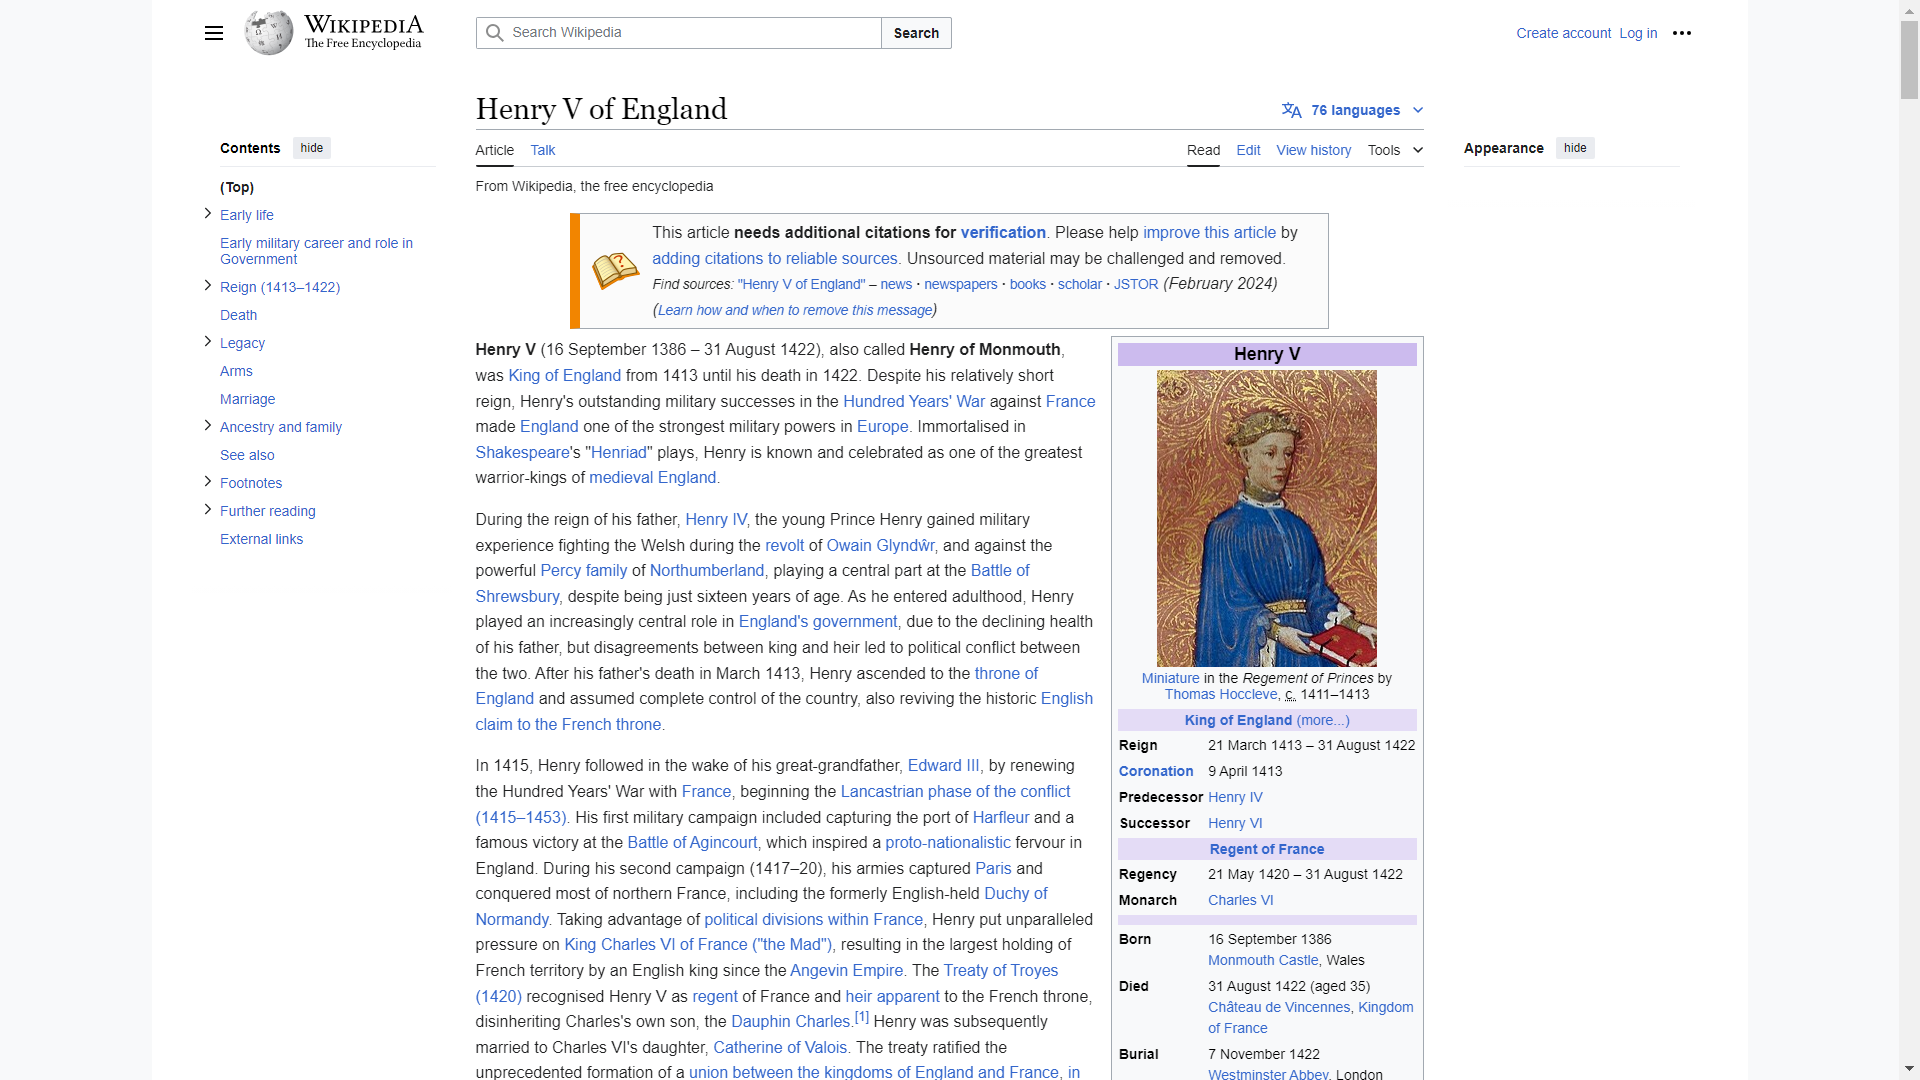

In [19]:

driver.set_window_size(1920,1080)
driver.get("https://en.wikipedia.org/wiki/Henry_V_of_England")

# Take a screenshot and save it
screenshot_path = "henry.png"
driver.save_screenshot(screenshot_path)

# Close the browser

# Display the screenshot in Colab
from IPython.display import Image, display
display(Image(filename=screenshot_path))


In [70]:
def find_element(elements, element_type, search_text, threshold=30):
    """
    Finds the element of a certain type with the highest similarity to the search_text using fuzzy matching.
    
    :param elements: List of UIElement objects.
    :param element_type: The type of the element to match.
    :param search_text: The text to search for within the elements.
    :param threshold: The minimum matching score to consider (default 80).
    :return: The element with the highest similarity score above the threshold or None if no match is found.
    """
    best_match = None
    highest_score = threshold  # Start with the threshold as the lowest acceptable score

    for element in elements:
        if element["class"].lower() == element_type.lower():
            print("YES")
            matches = process.extract(search_text, element["text"], limit=None)
            for match in matches:
                text, score = match
                if score >= highest_score:
                    highest_score = score
                    best_match = element

    return best_match

In [71]:
from PIL import Image, ImageDraw

def draw_bounding_box(image_path, box, box_color='red', line_thickness=5):
    """
    Draws a bounding box on an image.
    
    :param image_path: Path to the original image file.
    :param box: A tuple (x, y, width, height) defining the bounding box.
    :param output_path: Path where the modified image will be saved.
    :param box_color: Color of the bounding box (default is 'red').
    :param line_thickness: Thickness of the box lines (default is 5).
    """
    # Open the image
    with Image.open(image_path) as img:
        draw = ImageDraw.Draw(img)
        # Calculate the bottom right coordinates
        draw.rectangle(box, outline=box_color, width=line_thickness)
        # Draw the rectangle
        # Save the image with the bounding box
        img.show()



In [72]:
elem = find_element(elements,'image','',30)
draw_bounding_box("henry.png",elem["box"])

YES
YES
YES
YES
YES


TypeError: 'NoneType' object is not subscriptable